<a href="https://colab.research.google.com/github/TonyNgcn/meme-classification/blob/master/sernet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are two different kind of GPU in colab，K80 or T4. K80 has only 11G+ memory while T4 have 15G memory. K80 can't run this program. If you get a K80 GPU, you should close this page and wait until you get a T4 GPU.  

The following cell is for you to check your GPU.


In [0]:
!nvidia-smi

Tue Jun 25 03:51:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

The following two cell is for the original Cifar10 dataset, copied from https://github.com/taki0112/SENet-Tensorflow 

In [0]:
# -*- coding:utf-8 -*-

import os
import sys
import time
import pickle
import random
import numpy as np

class_num = 10
image_size = 32
img_channels = 3


# ========================================================== #
# ├─ prepare_data()
#  ├─ download training data if not exist by download_data()
#  ├─ load data by load_data()
#  └─ shuffe and return data
# ========================================================== #



def download_data():
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    fname = 'cifar-10-python.tar.gz'
    fpath = './' + dirname

    download = False
    if os.path.exists(fpath) or os.path.isfile(fname):
        download = False
        print("DataSet aready exist!")
    else:
        download = True
    if download:
        print('Downloading data from', origin)
        import urllib.request
        import tarfile

        def reporthook(count, block_size, total_size):
            global start_time
            if count == 0:
                start_time = time.time()
                return
            duration = time.time() - start_time
            progress_size = int(count * block_size)
            speed = int(progress_size / (1024 * duration))
            percent = min(int(count * block_size * 100 / total_size), 100)
            sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                             (percent, progress_size / (1024 * 1024), speed, duration))
            sys.stdout.flush()

        urllib.request.urlretrieve(origin, fname, reporthook)
        print('Download finished. Start extract!', origin)
        if (fname.endswith("tar.gz")):
            tar = tarfile.open(fname, "r:gz")
            tar.extractall()
            tar.close()
        elif (fname.endswith("tar")):
            tar = tarfile.open(fname, "r:")
            tar.extractall()
            tar.close()


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_data_one(file):
    batch = unpickle(file)
    data = batch[b'data']
    labels = batch[b'labels']
    print("Loading %s : %d." % (file, len(data)))
    return data, labels


def load_data(files, data_dir, label_count):
    global image_size, img_channels
    data, labels = load_data_one(data_dir + '/' + files[0])
    for f in files[1:]:
        data_n, labels_n = load_data_one(data_dir + '/' + f)
        data = np.append(data, data_n, axis=0)
        labels = np.append(labels, labels_n, axis=0)
    labels = np.array([[float(i == label) for i in range(label_count)] for label in labels])
    data = data.reshape([-1, img_channels, image_size, image_size])
    data = data.transpose([0, 2, 3, 1])
    return data, labels


def prepare_data():
    print("======Loading data======")
    download_data()
    data_dir = './cifar-10-batches-py'
    image_dim = image_size * image_size * img_channels
    meta = unpickle(data_dir + '/batches.meta')

    label_names = meta[b'label_names']
    label_count = len(label_names)
    train_files = ['data_batch_%d' % d for d in range(1, 6)]
    train_data, train_labels = load_data(train_files, data_dir, label_count)
    test_data, test_labels = load_data(['test_batch'], data_dir, label_count)

    print("Train data:", np.shape(train_data), np.shape(train_labels))
    print("Test data :", np.shape(test_data), np.shape(test_labels))
    print("======Load finished======")

    print("======Shuffling data======")
    indices = np.random.permutation(len(train_data))
    train_data = train_data[indices]
    train_labels = train_labels[indices]
    print("======Prepare Finished======")

    return train_data, train_labels, test_data, test_labels


# ========================================================== #
# ├─ _random_crop()
# ├─ _random_flip_leftright()
# ├─ data_augmentation()
# └─ color_preprocessing()
# ========================================================== #

def _random_crop(batch, crop_shape, padding=None):
    oshape = np.shape(batch[0])

    if padding:
        oshape = (oshape[0] + 2 * padding, oshape[1] + 2 * padding)
    new_batch = []
    npad = ((padding, padding), (padding, padding), (0, 0))
    for i in range(len(batch)):
        new_batch.append(batch[i])
        if padding:
            new_batch[i] = np.lib.pad(batch[i], pad_width=npad,
                                      mode='constant', constant_values=0)
        nh = random.randint(0, oshape[0] - crop_shape[0])
        nw = random.randint(0, oshape[1] - crop_shape[1])
        new_batch[i] = new_batch[i][nh:nh + crop_shape[0],
                       nw:nw + crop_shape[1]]
    return new_batch


def _random_flip_leftright(batch):
    for i in range(len(batch)):
        if bool(random.getrandbits(1)):
            batch[i] = np.fliplr(batch[i])
    return batch


def color_preprocessing(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train[:, :, :, 0] = (x_train[:, :, :, 0] - np.mean(x_train[:, :, :, 0])) / np.std(x_train[:, :, :, 0])
    x_train[:, :, :, 1] = (x_train[:, :, :, 1] - np.mean(x_train[:, :, :, 1])) / np.std(x_train[:, :, :, 1])
    x_train[:, :, :, 2] = (x_train[:, :, :, 2] - np.mean(x_train[:, :, :, 2])) / np.std(x_train[:, :, :, 2])

    x_test[:, :, :, 0] = (x_test[:, :, :, 0] - np.mean(x_test[:, :, :, 0])) / np.std(x_test[:, :, :, 0])
    x_test[:, :, :, 1] = (x_test[:, :, :, 1] - np.mean(x_test[:, :, :, 1])) / np.std(x_test[:, :, :, 1])
    x_test[:, :, :, 2] = (x_test[:, :, :, 2] - np.mean(x_test[:, :, :, 2])) / np.std(x_test[:, :, :, 2])

    return x_train, x_test


def data_augmentation(batch):
    batch = _random_flip_leftright(batch)
    batch = _random_crop(batch, [32, 32], 4)
    return batch

In [3]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1
cardinality = 8 # how many split ?
blocks = 3 # res_block ! (split + transition)
depth = 64 # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""

reduction_ratio = 4

batch_size = 128

iteration = 391
# 128 * 391 ~ 50,000

test_iteration = 10

total_epochs = 100

def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
    with tf.name_scope(layer_name):
        network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride, padding=padding)
        return network

def Global_Average_Pooling(x):
    return global_avg_pool(x, name='Global_avg_pooling')

def Average_pooling(x, pool_size=[2,2], stride=2, padding='SAME'):
    return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)

def Batch_Normalization(x, training, scope):
    with arg_scope([batch_norm],
                   scope=scope,
                   updates_collections=None,
                   decay=0.9,
                   center=True,
                   scale=True,
                   zero_debias_moving_mean=True) :
        return tf.cond(training,
                       lambda : batch_norm(inputs=x, is_training=training, reuse=None),
                       lambda : batch_norm(inputs=x, is_training=training, reuse=True))

def Relu(x):
    return tf.nn.relu(x)

def Sigmoid(x) :
    return tf.nn.sigmoid(x)

def Concatenation(layers) :
    return tf.concat(layers, axis=3)

def Fully_connected(x, units=class_num, layer_name='fully_connected') :
    with tf.name_scope(layer_name) :
        return tf.layers.dense(inputs=x, use_bias=False, units=units)

def Evaluate(sess):
    test_acc = 0.0
    test_loss = 0.0
    test_pre_index = 0
    add = 1000

    for it in range(test_iteration):
        test_batch_x = test_x[test_pre_index: test_pre_index + add]
        test_batch_y = test_y[test_pre_index: test_pre_index + add]
        test_pre_index = test_pre_index + add

        test_feed_dict = {
            x: test_batch_x,
            label: test_batch_y,
            learning_rate: epoch_learning_rate,
            training_flag: False
        }

        loss_, acc_ = sess.run([cost, accuracy], feed_dict=test_feed_dict)

        test_loss += loss_
        test_acc += acc_

    test_loss /= test_iteration # average loss
    test_acc /= test_iteration # average accuracy

    summary = tf.Summary(value=[tf.Summary.Value(tag='test_loss', simple_value=test_loss),
                                tf.Summary.Value(tag='test_accuracy', simple_value=test_acc)])

    return test_acc, test_loss, summary

class SE_ResNeXt():
    def __init__(self, x, training):
        self.training = training
        self.model = self.Build_SEnet(x)

    def first_layer(self, x, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            return x

    def transform_layer(self, x, stride, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=depth, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            x = conv_layer(x, filter=depth, kernel=[3,3], stride=stride, layer_name=scope+'_conv2')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch2')
            x = Relu(x)
            return x

    def transition_layer(self, x, out_dim, scope):
        with tf.name_scope(scope):
            x = conv_layer(x, filter=out_dim, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            # x = Relu(x)

            return x

    def split_layer(self, input_x, stride, layer_name):
        with tf.name_scope(layer_name) :
            layers_split = list()
            for i in range(cardinality) :
                splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
                layers_split.append(splits)

            return Concatenation(layers_split)

    def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
        with tf.name_scope(layer_name) :


            squeeze = Global_Average_Pooling(input_x)

            excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name+'_fully_connected1')
            excitation = Relu(excitation)
            excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name+'_fully_connected2')
            excitation = Sigmoid(excitation)

            excitation = tf.reshape(excitation, [-1,1,1,out_dim])
            scale = input_x * excitation

            return scale

    def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
        # split + transform(bottleneck) + transition + merge
        # input_dim = input_x.get_shape().as_list()[-1]

        for i in range(res_block):
            input_dim = int(np.shape(input_x)[-1])

            if input_dim * 2 == out_dim:
                flag = True
                stride = 2
                channel = input_dim // 2
            else:
                flag = False
                stride = 1

            x = self.split_layer(input_x, stride=stride, layer_name='split_layer_'+layer_num+'_'+str(i))
            x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_'+layer_num+'_'+str(i))
            x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio, layer_name='squeeze_layer_'+layer_num+'_'+str(i))

            if flag is True :
                pad_input_x = Average_pooling(input_x)
                pad_input_x = tf.pad(pad_input_x, [[0, 0], [0, 0], [0, 0], [channel, channel]]) # [?, height, width, channel]
            else :
                pad_input_x = input_x

            input_x = Relu(x + pad_input_x)

        return input_x


    def Build_SEnet(self, input_x):
        # only cifar10 architecture

        input_x = self.first_layer(input_x, scope='first_layer')

        x = self.residual_layer(input_x, out_dim=64, layer_num='1')
        x = self.residual_layer(x, out_dim=128, layer_num='2')
        x = self.residual_layer(x, out_dim=256, layer_num='3')

        x = Global_Average_Pooling(x)
        x = flatten(x)

        x = Fully_connected(x, layer_name='final_fully_connected')
        return x


train_x, train_y, test_x, test_y = prepare_data()
train_x, test_x = color_preprocessing(train_x, test_x)


# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)


learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())

with tf.Session() as sess:
# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess :
    ckpt = tf.train.get_checkpoint_state('./model')
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('./logs', sess.graph)

    epoch_learning_rate = init_learning_rate
    for epoch in range(1, total_epochs + 1):
        if epoch % 30 == 0 :
            epoch_learning_rate = epoch_learning_rate / 10

        pre_index = 0
        train_acc = 0.0
        train_loss = 0.0

        for step in range(1, iteration + 1):
            if pre_index + batch_size < 50000:
                batch_x = train_x[pre_index: pre_index + batch_size]
                batch_y = train_y[pre_index: pre_index + batch_size]
            else:
                batch_x = train_x[pre_index:]
                batch_y = train_y[pre_index:]

            batch_x = data_augmentation(batch_x)

            train_feed_dict = {
                x: batch_x,
                label: batch_y,
                learning_rate: epoch_learning_rate,
                training_flag: True
            }

            _, batch_loss = sess.run([train, cost], feed_dict=train_feed_dict)
            batch_acc = accuracy.eval(feed_dict=train_feed_dict)

            train_loss += batch_loss
            train_acc += batch_acc
            pre_index += batch_size


        train_loss /= iteration # average loss
        train_acc /= iteration # average accuracy

        train_summary = tf.Summary(value=[tf.Summary.Value(tag='train_loss', simple_value=train_loss),
                                          tf.Summary.Value(tag='train_accuracy', simple_value=train_acc)])

        test_acc, test_loss, test_summary = Evaluate(sess)

        summary_writer.add_summary(summary=train_summary, global_step=epoch)
        summary_writer.add_summary(summary=test_summary, global_step=epoch)
        summary_writer.flush()

        line = "epoch: %d/%d, train_loss: %.4f, train_acc: %.4f, test_loss: %.4f, test_acc: %.4f \n" % (
            epoch, total_epochs, train_loss, train_acc, test_loss, test_acc)
        print(line)

        with open('logs.txt', 'a') as f:
            f.write(line)

        saver.save(sess=sess, save_path='./model/ResNeXt.ckpt')


W0625 03:51:51.392901 139670140077952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0625 03:51:51.395198 139670140077952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0625 03:51:51.413164 139670140077952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0625 03:51:51.421532 139670140077952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0625 03:51:51.434395 139670140077952 deprecation_wrapper.py:119] From /usr/local/lib/

======Loading data======
...100%, 162 MB, 7753 KB/s, 21 seconds passedDownload finished. Start extract! http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Loading ./cifar-10-batches-py/data_batch_1 : 10000.
Loading ./cifar-10-batches-py/data_batch_2 : 10000.
Loading ./cifar-10-batches-py/data_batch_3 : 10000.
Loading ./cifar-10-batches-py/data_batch_4 : 10000.
Loading ./cifar-10-batches-py/data_batch_5 : 10000.
Loading ./cifar-10-batches-py/test_batch : 10000.
Train data: (50000, 32, 32, 3) (50000, 10)
Test data : (10000, 32, 32, 3) (10000, 10)
======Load finished======
======Shuffling data======
======Prepare Finished======


W0625 03:52:24.557919 139670140077952 deprecation.py:323] From <ipython-input-3-4764bd4f8c0e>:35: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0625 03:52:24.568286 139670140077952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 03:52:30.390635 139670140077952 deprecation.py:323] From <ipython-input-3-4764bd4f8c0e>:67: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0625 03:52:44.217711 139670140077952 deprecation.py:323] From <ipython-input

epoch: 1/100, train_loss: 1.3510, train_acc: 0.6204, test_loss: 0.9925, test_acc: 0.6460 

epoch: 2/100, train_loss: 0.8093, train_acc: 0.8135, test_loss: 0.7507, test_acc: 0.7388 

epoch: 3/100, train_loss: 0.6366, train_acc: 0.8754, test_loss: 0.6823, test_acc: 0.7635 

epoch: 4/100, train_loss: 0.5508, train_acc: 0.9044, test_loss: 0.5894, test_acc: 0.7914 

epoch: 5/100, train_loss: 0.5024, train_acc: 0.9215, test_loss: 0.5798, test_acc: 0.7994 

epoch: 6/100, train_loss: 0.4716, train_acc: 0.9335, test_loss: 0.4870, test_acc: 0.8327 

epoch: 7/100, train_loss: 0.4455, train_acc: 0.9422, test_loss: 0.5237, test_acc: 0.8196 

epoch: 8/100, train_loss: 0.4221, train_acc: 0.9510, test_loss: 0.5288, test_acc: 0.8174 

epoch: 9/100, train_loss: 0.4106, train_acc: 0.9555, test_loss: 0.4605, test_acc: 0.8418 

epoch: 10/100, train_loss: 0.3959, train_acc: 0.9611, test_loss: 0.5516, test_acc: 0.8155 

epoch: 11/100, train_loss: 0.3838, train_acc: 0.9625, test_loss: 0.4387, test_acc: 0.8480

The following cells are written or modified by TonyNg, published on https://github.com/TonyNgcn/meme-classification 
You can download my model on https://drive.google.com/file/d/1zDwXJxuLPkODAG99Yvd7VLCqihPTKkUS/view?usp=sharing

In [0]:
!wget https://github.com/TonyNgcn/meme-classification/raw/master/ok.zip
!unzip ok.zip
!ls

--2019-06-14 08:50:02--  https://github.com/TonyNgcn/meme-classification/raw/master/ok.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TonyNgcn/meme-classification/master/ok.zip [following]
--2019-06-14 08:50:03--  https://raw.githubusercontent.com/TonyNgcn/meme-classification/master/ok.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5510451 (5.3M) [application/zip]
Saving to: ‘ok.zip’

ok.zip              100%[===================>]   5.25M  --.-KB/s    in 0.1s    

2019-06-14 08:50:03 (53.9 MB/s) - ‘ok.zip’ saved [5510451/5510451]

Archive:  ok.zip
   creating: ok/
  inflating: ok/00_0.j

In [0]:
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import os
import random
class_num = 10
image_size = 32
img_channels = 3


def get_rgb_vector(imgPath):
	img = cv.imread(imgPath)
	# img=cv.resize(img,(32,32))
	B, G, R = cv.split(img)
	B = np.reshape(B, (1, 1024))
	G = np.reshape(G, (1, 1024))
	R = np.reshape(R, (1, 1024))
	vector = np.concatenate((R, G, B), axis=1)
	return vector


def prepare_data():
	dir='./ok'
	labels=[]
	data=[]
	for i,imgpath in enumerate(os.listdir(dir)):
		# if i==0:
		# 	data=get_rgb_vector(dir+'/'+imgpath)
		# else:
		# 	data = np.concatenate((data,get_rgb_vector(dir+'/'+imgpath)), axis=0)

		data.append(cv.imread(dir+'/'+imgpath))
		labels.append(int(imgpath[:2]))
	labels=np.array(labels)
	data=np.array(data)

	train_data, test_data, train_labels, test_labels = train_test_split(data,labels,test_size=0.2)

	onehot=OneHotEncoder()
	train_labels=onehot.fit_transform(train_labels.reshape(-1,1)).toarray()
	test_labels=onehot.fit_transform(test_labels.reshape(-1,1)).toarray()

	return train_data, train_labels, test_data, test_labels


def _random_crop(batch, crop_shape, padding=None):
    oshape = np.shape(batch[0])

    if padding:
        oshape = (oshape[0] + 2 * padding, oshape[1] + 2 * padding)
    new_batch = []
    npad = ((padding, padding), (padding, padding), (0, 0))
    for i in range(len(batch)):
        new_batch.append(batch[i])
        if padding:
            new_batch[i] = np.lib.pad(batch[i], pad_width=npad,
                                      mode='constant', constant_values=0)
        nh = random.randint(0, oshape[0] - crop_shape[0])
        nw = random.randint(0, oshape[1] - crop_shape[1])
        new_batch[i] = new_batch[i][nh:nh + crop_shape[0],
                       nw:nw + crop_shape[1]]
    return new_batch


def _random_flip_leftright(batch):
    for i in range(len(batch)):
        if bool(random.getrandbits(1)):
            batch[i] = np.fliplr(batch[i])
    return batch


def color_preprocessing(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train[:, :, :, 0] = (x_train[:, :, :, 0] - np.mean(x_train[:, :, :, 0])) / np.std(x_train[:, :, :, 0])
    x_train[:, :, :, 1] = (x_train[:, :, :, 1] - np.mean(x_train[:, :, :, 1])) / np.std(x_train[:, :, :, 1])
    x_train[:, :, :, 2] = (x_train[:, :, :, 2] - np.mean(x_train[:, :, :, 2])) / np.std(x_train[:, :, :, 2])

    x_test[:, :, :, 0] = (x_test[:, :, :, 0] - np.mean(x_test[:, :, :, 0])) / np.std(x_test[:, :, :, 0])
    x_test[:, :, :, 1] = (x_test[:, :, :, 1] - np.mean(x_test[:, :, :, 1])) / np.std(x_test[:, :, :, 1])
    x_test[:, :, :, 2] = (x_test[:, :, :, 2] - np.mean(x_test[:, :, :, 2])) / np.std(x_test[:, :, :, 2])

    return x_train, x_test


def data_augmentation(batch):
    batch = _random_flip_leftright(batch)
    batch = _random_crop(batch, [32, 32], 4)
    return batch

The following cell is modified from SE_ResNeXt.py in order to fit the dataset by myself.(The meme picture)-v1.3

In [0]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import keras.layers
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1
cardinality = 8 # how many split ?
blocks = 3 # res_block ! (split + transition)
depth = 64 # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""

reduction_ratio = 4
class_num=10
batch_size = 128

# iteration = 391
# 128 * 391 ~ 50,000

iteration=36
# 128*36~4608

test_iteration = 10

total_epochs = 100

def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
    with tf.name_scope(layer_name):
        network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride, padding=padding)
        return network

def Global_Average_Pooling(x):
    return global_avg_pool(x, name='Global_avg_pooling')

def Average_pooling(x, pool_size=[2,2], stride=2, padding='SAME'):
    return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)

def Batch_Normalization(x, training, scope):
    with arg_scope([batch_norm],
                   scope=scope,
                   updates_collections=None,
                   decay=0.9,
                   center=True,
                   scale=True,
                   zero_debias_moving_mean=True) :
        return tf.cond(training,
                       lambda : batch_norm(inputs=x, is_training=training, reuse=None),
                       lambda : batch_norm(inputs=x, is_training=training, reuse=True))

def Relu(x):
    return tf.nn.relu(x)

def Sigmoid(x) :
    return tf.nn.sigmoid(x)

def Concatenation(layers) :
    return tf.concat(layers, axis=3)

def Fully_connected(x, units=class_num, layer_name='fully_connected') :
    with tf.name_scope(layer_name) :
        return tf.layers.dense(inputs=x, use_bias=False, units=units)

def Evaluate(sess):
    test_acc = 0.0
    test_loss = 0.0
    test_pre_index = 0
    add = int(len(test_x)/test_iteration)

    for it in range(test_iteration):
        test_batch_x = test_x[test_pre_index: test_pre_index + add]
        test_batch_y = test_y[test_pre_index: test_pre_index + add]
        test_pre_index = test_pre_index + add

        test_feed_dict = {
            x: test_batch_x,
            label: test_batch_y,
            learning_rate: epoch_learning_rate,
            training_flag: False
        }

        loss_, acc_ = sess.run([cost, accuracy], feed_dict=test_feed_dict)

        test_loss += loss_
        test_acc += acc_

    test_loss /= test_iteration # average loss
    test_acc /= test_iteration # average accuracy

    summary = tf.Summary(value=[tf.Summary.Value(tag='test_loss', simple_value=test_loss),
                                tf.Summary.Value(tag='test_accuracy', simple_value=test_acc)])

    return test_acc, test_loss, summary

class SE_ResNeXt():
    def __init__(self, x, training):
        self.training = training
        self.model = self.Build_SEnet(x)

    def first_layer(self, x, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            return x

    def transform_layer(self, x, stride, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=depth, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            x = conv_layer(x, filter=depth, kernel=[3,3], stride=stride, layer_name=scope+'_conv2')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch2')
            x = Relu(x)
            return x

    def transition_layer(self, x, out_dim, scope):
        with tf.name_scope(scope):
            x = conv_layer(x, filter=out_dim, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            # x = Relu(x)

            return x

    def split_layer(self, input_x, stride, layer_name):
        with tf.name_scope(layer_name) :
            layers_split = list()
            for i in range(cardinality) :
                splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
                layers_split.append(splits)

            return Concatenation(layers_split)

    def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
        with tf.name_scope(layer_name) :


            squeeze = Global_Average_Pooling(input_x)

            excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name+'_fully_connected1')
            excitation = Relu(excitation)
            excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name+'_fully_connected2')
            excitation = Sigmoid(excitation)

            excitation = tf.reshape(excitation, [-1,1,1,out_dim])
            scale = input_x * excitation

            return scale

    def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
        # split + transform(bottleneck) + transition + merge
        # input_dim = input_x.get_shape().as_list()[-1]

        for i in range(res_block):
            input_dim = int(np.shape(input_x)[-1])

            if input_dim * 2 == out_dim:
                flag = True
                stride = 2
                channel = input_dim // 2
            else:
                flag = False
                stride = 1

            x = self.split_layer(input_x, stride=stride, layer_name='split_layer_'+layer_num+'_'+str(i))
            x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_'+layer_num+'_'+str(i))
            x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio, layer_name='squeeze_layer_'+layer_num+'_'+str(i))

            if flag is True :
                pad_input_x = Average_pooling(input_x)
                pad_input_x = tf.pad(pad_input_x, [[0, 0], [0, 0], [0, 0], [channel, channel]]) # [?, height, width, channel]
            else :
                pad_input_x = input_x

            input_x = Relu(x + pad_input_x)

        return input_x


    def Build_SEnet(self, input_x):
        # only cifar10 architecture

        input_x = self.first_layer(input_x, scope='first_layer')

        x = self.residual_layer(input_x, out_dim=64, layer_num='1')
        x = self.residual_layer(x, out_dim=128, layer_num='2')
        x = self.residual_layer(x, out_dim=256, layer_num='3')

        x = Global_Average_Pooling(x)
        x = flatten(x)

        x = Fully_connected(x, layer_name='final_fully_connected')
        return x


train_x, train_y, test_x, test_y = prepare_data()
train_x, test_x = color_preprocessing(train_x, test_x)


# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)


learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())

# with tf.Session() as sess:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess :
    ckpt = tf.train.get_checkpoint_state('./model')
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('./logs', sess.graph)

    epoch_learning_rate = init_learning_rate
    for epoch in range(1, total_epochs + 1):
        if epoch % 30 == 0 :
            epoch_learning_rate = epoch_learning_rate / 10

        pre_index = 0
        train_acc = 0.0
        train_loss = 0.0

        for step in range(1, iteration + 1):
            if pre_index + batch_size < 4586:
                batch_x = train_x[pre_index: pre_index + batch_size]
                batch_y = train_y[pre_index: pre_index + batch_size]
            else:
                batch_x = train_x[pre_index:]
                batch_y = train_y[pre_index:]

            batch_x = data_augmentation(batch_x)

            train_feed_dict = {
                x: batch_x,
                label: batch_y,
                learning_rate: epoch_learning_rate,
                training_flag: True
            }

            _, batch_loss = sess.run([train, cost], feed_dict=train_feed_dict)
            batch_acc = accuracy.eval(feed_dict=train_feed_dict)

            train_loss += batch_loss
            train_acc += batch_acc
            pre_index += batch_size


        train_loss /= iteration # average loss
        train_acc /= iteration # average accuracy

        train_summary = tf.Summary(value=[tf.Summary.Value(tag='train_loss', simple_value=train_loss),
                                          tf.Summary.Value(tag='train_accuracy', simple_value=train_acc)])

        test_acc, test_loss, test_summary = Evaluate(sess)

        summary_writer.add_summary(summary=train_summary, global_step=epoch)
        summary_writer.add_summary(summary=test_summary, global_step=epoch)
        summary_writer.flush()

        line = "epoch: %d/%d, train_loss: %.4f, train_acc: %.4f, test_loss: %.4f, test_acc: %.4f \n" % (
            epoch, total_epochs, train_loss, train_acc, test_loss, test_acc)
        print(line)

        with open('logs.txt', 'a') as f:
            f.write(line)

        saver.save(sess=sess, save_path='./model/ResNeXt.ckpt')


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.average_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.
epoch: 1/100, train_loss: 1.5237, train_acc: 0.5992, test_loss: 2.5079, test_acc: 0.4474 

epoch: 2/100, train_loss: 0.7301, train_acc: 0.7969, test_loss: 0.9444, test_acc: 0.6298 

epoch: 3/100, train_loss: 0.5545, train_acc: 0.8560, test_loss: 0.8066, test_acc: 0.7211 

epoch: 4/100, train_loss: 0.4585, train_acc: 0.8890, test_loss: 2.7603, test_acc: 0.6351 

epoch: 5/100, train_loss: 0.3814, train_acc: 0.9119, test_loss: 0.6498, test_acc: 0.7798 

epoch: 6/100, train_loss: 0.3392, train_acc: 0.9330, test_loss: 0.6694, test_acc: 0.7640 

epoch: 7/100, train_loss: 0.2879, train_acc: 0.9489, test_loss: 0.5575, test_acc: 0.8123 

epoch: 8/100, train_loss: 0.2560, train_acc: 0.9570, test_loss: 

Then I will try to modify the model. First, I want to  add a residual_layer.(v1.4)



```
# Difference

    def Build_SEnet(self, input_x):
        # only cifar10 architecture

        input_x = self.first_layer(input_x, scope='first_layer')

        x = self.residual_layer(input_x, out_dim=64, layer_num='1')
        x = self.residual_layer(x, out_dim=128, layer_num='2')
        x = self.residual_layer(x, out_dim=256, layer_num='3')
        x = self.residual_layer(x, out_dim=512, layer_num='4')
        
        x = Global_Average_Pooling(x)
        x = flatten(x)

        x = Fully_connected(x, layer_name='final_fully_connected')
        return x
```



In [0]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import keras.layers
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1
cardinality = 8 # how many split ?
blocks = 3 # res_block ! (split + transition)
depth = 64 # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""

reduction_ratio = 4
class_num=10
batch_size = 128

# iteration = 391
# 128 * 391 ~ 50,000

iteration=36
# 128*36~4608

test_iteration = 10

total_epochs = 100

def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
    with tf.name_scope(layer_name):
        network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride, padding=padding)
        return network

def Global_Average_Pooling(x):
    return global_avg_pool(x, name='Global_avg_pooling')

def Average_pooling(x, pool_size=[2,2], stride=2, padding='SAME'):
    return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)

def Batch_Normalization(x, training, scope):
    with arg_scope([batch_norm],
                   scope=scope,
                   updates_collections=None,
                   decay=0.9,
                   center=True,
                   scale=True,
                   zero_debias_moving_mean=True) :
        return tf.cond(training,
                       lambda : batch_norm(inputs=x, is_training=training, reuse=None),
                       lambda : batch_norm(inputs=x, is_training=training, reuse=True))

def Relu(x):
    return tf.nn.relu(x)

def Sigmoid(x) :
    return tf.nn.sigmoid(x)

def Concatenation(layers) :
    return tf.concat(layers, axis=3)

def Fully_connected(x, units=class_num, layer_name='fully_connected') :
    with tf.name_scope(layer_name) :
        return tf.layers.dense(inputs=x, use_bias=False, units=units)

def Evaluate(sess):
    test_acc = 0.0
    test_loss = 0.0
    test_pre_index = 0
    add = int(len(test_x)/test_iteration)

    for it in range(test_iteration):
        test_batch_x = test_x[test_pre_index: test_pre_index + add]
        test_batch_y = test_y[test_pre_index: test_pre_index + add]
        test_pre_index = test_pre_index + add

        test_feed_dict = {
            x: test_batch_x,
            label: test_batch_y,
            learning_rate: epoch_learning_rate,
            training_flag: False
        }

        loss_, acc_ = sess.run([cost, accuracy], feed_dict=test_feed_dict)

        test_loss += loss_
        test_acc += acc_

    test_loss /= test_iteration # average loss
    test_acc /= test_iteration # average accuracy

    summary = tf.Summary(value=[tf.Summary.Value(tag='test_loss', simple_value=test_loss),
                                tf.Summary.Value(tag='test_accuracy', simple_value=test_acc)])

    return test_acc, test_loss, summary

class SE_ResNeXt():
    def __init__(self, x, training):
        self.training = training
        self.model = self.Build_SEnet(x)

    def first_layer(self, x, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            return x

    def transform_layer(self, x, stride, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=depth, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            x = conv_layer(x, filter=depth, kernel=[3,3], stride=stride, layer_name=scope+'_conv2')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch2')
            x = Relu(x)
            return x

    def transition_layer(self, x, out_dim, scope):
        with tf.name_scope(scope):
            x = conv_layer(x, filter=out_dim, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            # x = Relu(x)

            return x

    def split_layer(self, input_x, stride, layer_name):
        with tf.name_scope(layer_name) :
            layers_split = list()
            for i in range(cardinality) :
                splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
                layers_split.append(splits)

            return Concatenation(layers_split)

    def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
        with tf.name_scope(layer_name) :


            squeeze = Global_Average_Pooling(input_x)

            excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name+'_fully_connected1')
            excitation = Relu(excitation)
            excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name+'_fully_connected2')
            excitation = Sigmoid(excitation)

            excitation = tf.reshape(excitation, [-1,1,1,out_dim])
            scale = input_x * excitation

            return scale

    def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
        # split + transform(bottleneck) + transition + merge
        # input_dim = input_x.get_shape().as_list()[-1]

        for i in range(res_block):
            input_dim = int(np.shape(input_x)[-1])

            if input_dim * 2 == out_dim:
                flag = True
                stride = 2
                channel = input_dim // 2
            else:
                flag = False
                stride = 1

            x = self.split_layer(input_x, stride=stride, layer_name='split_layer_'+layer_num+'_'+str(i))
            x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_'+layer_num+'_'+str(i))
            x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio, layer_name='squeeze_layer_'+layer_num+'_'+str(i))

            if flag is True :
                pad_input_x = Average_pooling(input_x)
                pad_input_x = tf.pad(pad_input_x, [[0, 0], [0, 0], [0, 0], [channel, channel]]) # [?, height, width, channel]
            else :
                pad_input_x = input_x

            input_x = Relu(x + pad_input_x)

        return input_x


    def Build_SEnet(self, input_x):
        # only cifar10 architecture

        input_x = self.first_layer(input_x, scope='first_layer')

        x = self.residual_layer(input_x, out_dim=64, layer_num='1')
        x = self.residual_layer(x, out_dim=128, layer_num='2')
        x = self.residual_layer(x, out_dim=256, layer_num='3')
        x = self.residual_layer(x, out_dim=512, layer_num='4')
        
        x = Global_Average_Pooling(x)
        x = flatten(x)

        x = Fully_connected(x, layer_name='final_fully_connected')
        return x


train_x, train_y, test_x, test_y = prepare_data()
train_x, test_x = color_preprocessing(train_x, test_x)


# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)


learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())

# with tf.Session() as sess:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess :
    ckpt = tf.train.get_checkpoint_state('./model_v1_4')
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('./logs_v1_4', sess.graph)

    epoch_learning_rate = init_learning_rate
    for epoch in range(1, total_epochs + 1):
        if epoch % 30 == 0 :
            epoch_learning_rate = epoch_learning_rate / 10

        pre_index = 0
        train_acc = 0.0
        train_loss = 0.0

        for step in range(1, iteration + 1):
            if pre_index + batch_size < 4586:
                batch_x = train_x[pre_index: pre_index + batch_size]
                batch_y = train_y[pre_index: pre_index + batch_size]
            else:
                batch_x = train_x[pre_index:]
                batch_y = train_y[pre_index:]

            batch_x = data_augmentation(batch_x)

            train_feed_dict = {
                x: batch_x,
                label: batch_y,
                learning_rate: epoch_learning_rate,
                training_flag: True
            }

            _, batch_loss = sess.run([train, cost], feed_dict=train_feed_dict)
            batch_acc = accuracy.eval(feed_dict=train_feed_dict)

            train_loss += batch_loss
            train_acc += batch_acc
            pre_index += batch_size


        train_loss /= iteration # average loss
        train_acc /= iteration # average accuracy

        train_summary = tf.Summary(value=[tf.Summary.Value(tag='train_loss', simple_value=train_loss),
                                          tf.Summary.Value(tag='train_accuracy', simple_value=train_acc)])

        test_acc, test_loss, test_summary = Evaluate(sess)

        summary_writer.add_summary(summary=train_summary, global_step=epoch)
        summary_writer.add_summary(summary=test_summary, global_step=epoch)
        summary_writer.flush()

        line = "epoch: %d/%d, train_loss: %.4f, train_acc: %.4f, test_loss: %.4f, test_acc: %.4f \n" % (
            epoch, total_epochs, train_loss, train_acc, test_loss, test_acc)
        print(line)

        with open('logs.txt', 'a') as f:
            f.write(line)

        saver.save(sess=sess, save_path='./model_v1_4/ResNeXt_v1_4.ckpt')


W0614 03:01:58.283171 140268881917824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0614 03:01:58.284458 140268881917824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0614 03:01:58.300127 140268881917824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0614 03:01:58.309382 140268881917824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0614 03:01:58.322672 140268881917824 deprecation_wrapper.py:119] From /usr/local/lib/

epoch: 1/100, train_loss: 2.3858, train_acc: 0.5124, test_loss: 4.8741, test_acc: 0.5281 

epoch: 2/100, train_loss: 0.9540, train_acc: 0.7246, test_loss: 0.7517, test_acc: 0.7246 

epoch: 3/100, train_loss: 0.7260, train_acc: 0.7929, test_loss: 0.9107, test_acc: 0.7386 

epoch: 4/100, train_loss: 0.6091, train_acc: 0.8394, test_loss: 0.6927, test_acc: 0.8070 

epoch: 5/100, train_loss: 0.5034, train_acc: 0.8749, test_loss: 1.6319, test_acc: 0.7982 

epoch: 6/100, train_loss: 0.4252, train_acc: 0.9072, test_loss: 0.5680, test_acc: 0.7868 

epoch: 7/100, train_loss: 0.3835, train_acc: 0.9188, test_loss: 0.8279, test_acc: 0.7360 

epoch: 8/100, train_loss: 0.3374, train_acc: 0.9347, test_loss: 0.4425, test_acc: 0.8623 

epoch: 9/100, train_loss: 0.2989, train_acc: 0.9490, test_loss: 0.4798, test_acc: 0.8351 

epoch: 10/100, train_loss: 0.2607, train_acc: 0.9656, test_loss: 0.4250, test_acc: 0.8430 

epoch: 11/100, train_loss: 0.2380, train_acc: 0.9691, test_loss: 0.3194, test_acc: 0.8912

Then, I want to  decrease a residual_layer based on the original model.(v1.5)


```
# Difference

    def Build_SEnet(self, input_x):
        # only cifar10 architecture

        input_x = self.first_layer(input_x, scope='first_layer')

        x = self.residual_layer(input_x, out_dim=64, layer_num='1')
        x = self.residual_layer(x, out_dim=128, layer_num='2')

        
        x = Global_Average_Pooling(x)
        x = flatten(x)

        x = Fully_connected(x, layer_name='final_fully_connected')
        return x
```



In [0]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import keras.layers
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1
cardinality = 8 # how many split ?
blocks = 3 # res_block ! (split + transition)
depth = 64 # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""

reduction_ratio = 4
class_num=10
batch_size = 128

# iteration = 391
# 128 * 391 ~ 50,000

iteration=36
# 128*36~4608

test_iteration = 10

total_epochs = 100

def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
    with tf.name_scope(layer_name):
        network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride, padding=padding)
        return network

def Global_Average_Pooling(x):
    return global_avg_pool(x, name='Global_avg_pooling')

def Average_pooling(x, pool_size=[2,2], stride=2, padding='SAME'):
    return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)

def Batch_Normalization(x, training, scope):
    with arg_scope([batch_norm],
                   scope=scope,
                   updates_collections=None,
                   decay=0.9,
                   center=True,
                   scale=True,
                   zero_debias_moving_mean=True) :
        return tf.cond(training,
                       lambda : batch_norm(inputs=x, is_training=training, reuse=None),
                       lambda : batch_norm(inputs=x, is_training=training, reuse=True))

def Relu(x):
    return tf.nn.relu(x)

def Sigmoid(x) :
    return tf.nn.sigmoid(x)

def Concatenation(layers) :
    return tf.concat(layers, axis=3)

def Fully_connected(x, units=class_num, layer_name='fully_connected') :
    with tf.name_scope(layer_name) :
        return tf.layers.dense(inputs=x, use_bias=False, units=units)

def Evaluate(sess):
    test_acc = 0.0
    test_loss = 0.0
    test_pre_index = 0
    add = int(len(test_x)/test_iteration)

    for it in range(test_iteration):
        test_batch_x = test_x[test_pre_index: test_pre_index + add]
        test_batch_y = test_y[test_pre_index: test_pre_index + add]
        test_pre_index = test_pre_index + add

        test_feed_dict = {
            x: test_batch_x,
            label: test_batch_y,
            learning_rate: epoch_learning_rate,
            training_flag: False
        }

        loss_, acc_ = sess.run([cost, accuracy], feed_dict=test_feed_dict)

        test_loss += loss_
        test_acc += acc_

    test_loss /= test_iteration # average loss
    test_acc /= test_iteration # average accuracy

    summary = tf.Summary(value=[tf.Summary.Value(tag='test_loss', simple_value=test_loss),
                                tf.Summary.Value(tag='test_accuracy', simple_value=test_acc)])

    return test_acc, test_loss, summary

class SE_ResNeXt():
    def __init__(self, x, training):
        self.training = training
        self.model = self.Build_SEnet(x)

    def first_layer(self, x, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            return x

    def transform_layer(self, x, stride, scope):
        with tf.name_scope(scope) :
            x = conv_layer(x, filter=depth, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            x = Relu(x)

            x = conv_layer(x, filter=depth, kernel=[3,3], stride=stride, layer_name=scope+'_conv2')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch2')
            x = Relu(x)
            return x

    def transition_layer(self, x, out_dim, scope):
        with tf.name_scope(scope):
            x = conv_layer(x, filter=out_dim, kernel=[1,1], stride=1, layer_name=scope+'_conv1')
            x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
            # x = Relu(x)

            return x

    def split_layer(self, input_x, stride, layer_name):
        with tf.name_scope(layer_name) :
            layers_split = list()
            for i in range(cardinality) :
                splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
                layers_split.append(splits)

            return Concatenation(layers_split)

    def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
        with tf.name_scope(layer_name) :


            squeeze = Global_Average_Pooling(input_x)

            excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name+'_fully_connected1')
            excitation = Relu(excitation)
            excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name+'_fully_connected2')
            excitation = Sigmoid(excitation)

            excitation = tf.reshape(excitation, [-1,1,1,out_dim])
            scale = input_x * excitation

            return scale

    def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
        # split + transform(bottleneck) + transition + merge
        # input_dim = input_x.get_shape().as_list()[-1]

        for i in range(res_block):
            input_dim = int(np.shape(input_x)[-1])

            if input_dim * 2 == out_dim:
                flag = True
                stride = 2
                channel = input_dim // 2
            else:
                flag = False
                stride = 1

            x = self.split_layer(input_x, stride=stride, layer_name='split_layer_'+layer_num+'_'+str(i))
            x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_'+layer_num+'_'+str(i))
            x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio, layer_name='squeeze_layer_'+layer_num+'_'+str(i))

            if flag is True :
                pad_input_x = Average_pooling(input_x)
                pad_input_x = tf.pad(pad_input_x, [[0, 0], [0, 0], [0, 0], [channel, channel]]) # [?, height, width, channel]
            else :
                pad_input_x = input_x

            input_x = Relu(x + pad_input_x)

        return input_x


    def Build_SEnet(self, input_x):
        # only cifar10 architecture

        input_x = self.first_layer(input_x, scope='first_layer')

        x = self.residual_layer(input_x, out_dim=64, layer_num='1')
        x = self.residual_layer(x, out_dim=128, layer_num='2')


        x = Global_Average_Pooling(x)
        x = flatten(x)

        x = Fully_connected(x, layer_name='final_fully_connected')
        return x


train_x, train_y, test_x, test_y = prepare_data()
train_x, test_x = color_preprocessing(train_x, test_x)


# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)


learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())

# with tf.Session() as sess:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess :
    ckpt = tf.train.get_checkpoint_state('./model_v1_5')
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('./logs_v1_5', sess.graph)

    epoch_learning_rate = init_learning_rate
    for epoch in range(1, total_epochs + 1):
        if epoch % 30 == 0 :
            epoch_learning_rate = epoch_learning_rate / 10

        pre_index = 0
        train_acc = 0.0
        train_loss = 0.0

        for step in range(1, iteration + 1):
            if pre_index + batch_size < 4586:
                batch_x = train_x[pre_index: pre_index + batch_size]
                batch_y = train_y[pre_index: pre_index + batch_size]
            else:
                batch_x = train_x[pre_index:]
                batch_y = train_y[pre_index:]

            batch_x = data_augmentation(batch_x)

            train_feed_dict = {
                x: batch_x,
                label: batch_y,
                learning_rate: epoch_learning_rate,
                training_flag: True
            }

            _, batch_loss = sess.run([train, cost], feed_dict=train_feed_dict)
            batch_acc = accuracy.eval(feed_dict=train_feed_dict)

            train_loss += batch_loss
            train_acc += batch_acc
            pre_index += batch_size


        train_loss /= iteration # average loss
        train_acc /= iteration # average accuracy

        train_summary = tf.Summary(value=[tf.Summary.Value(tag='train_loss', simple_value=train_loss),
                                          tf.Summary.Value(tag='train_accuracy', simple_value=train_acc)])

        test_acc, test_loss, test_summary = Evaluate(sess)

        summary_writer.add_summary(summary=train_summary, global_step=epoch)
        summary_writer.add_summary(summary=test_summary, global_step=epoch)
        summary_writer.flush()

        line = "epoch: %d/%d, train_loss: %.4f, train_acc: %.4f, test_loss: %.4f, test_acc: %.4f \n" % (
            epoch, total_epochs, train_loss, train_acc, test_loss, test_acc)
        print(line)

        with open('logs.txt', 'a') as f:
            f.write(line)

        saver.save(sess=sess, save_path='./model_v1_5/ResNeXt_v1_5.ckpt')


W0614 08:51:05.366146 140404685391744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0614 08:51:05.367459 140404685391744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0614 08:51:05.383720 140404685391744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0614 08:51:05.393355 140404685391744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0614 08:51:05.405952 140404685391744 deprecation_wrapper.py:119] From /usr/local/lib/

epoch: 1/100, train_loss: 1.2263, train_acc: 0.6386, test_loss: 1.2319, test_acc: 0.5851 

epoch: 2/100, train_loss: 0.7130, train_acc: 0.7950, test_loss: 1.8093, test_acc: 0.5675 

epoch: 3/100, train_loss: 0.5484, train_acc: 0.8552, test_loss: 2.5288, test_acc: 0.5474 

epoch: 4/100, train_loss: 0.4564, train_acc: 0.8838, test_loss: 0.7317, test_acc: 0.7491 

epoch: 5/100, train_loss: 0.3989, train_acc: 0.9044, test_loss: 1.1154, test_acc: 0.6649 

epoch: 6/100, train_loss: 0.3580, train_acc: 0.9209, test_loss: 0.4168, test_acc: 0.8553 

epoch: 7/100, train_loss: 0.2965, train_acc: 0.9367, test_loss: 1.0200, test_acc: 0.7228 

epoch: 8/100, train_loss: 0.2547, train_acc: 0.9517, test_loss: 1.3517, test_acc: 0.7167 

epoch: 9/100, train_loss: 0.2112, train_acc: 0.9674, test_loss: 0.7040, test_acc: 0.7807 

epoch: 10/100, train_loss: 0.2036, train_acc: 0.9744, test_loss: 0.4269, test_acc: 0.8711 

epoch: 11/100, train_loss: 0.1874, train_acc: 0.9794, test_loss: 0.6190, test_acc: 0.8211

The following cell is to compress the model we trained.

In [0]:
!zip -r ResNeXt_model.zip model
!ls -l

updating: model/ (stored 0%)
  adding: model/ResNeXt.ckpt.meta (deflated 95%)
  adding: model/ResNeXt.ckpt.data-00000-of-00001 (deflated 7%)
  adding: model/ResNeXt.ckpt.index (deflated 76%)
  adding: model/checkpoint (deflated 40%)
total 36896
drwxr-xr-x 2 root root     4096 May 31 13:26 logs
-rw-r--r-- 1 root root     9092 May 31 14:32 logs.txt
drwxr-xr-x 2 root root     4096 May 31 14:32 model
drwxr-xr-x 2 root root   163840 May 30 21:41 ok
-rw-r--r-- 1 root root  5510451 May 31 13:23 ok.zip
-rw-r--r-- 1 root root 32079501 May 31 16:49 ResNeXt_model.zip
drwxr-xr-x 1 root root     4096 May 24 16:08 sample_data


In [0]:
!zip -r ResNeXt_model_v1_4.zip model_v1_4
!ls -l

  adding: model_v1_4/ (stored 0%)
  adding: model_v1_4/ResNeXt_v1_4.ckpt.data-00000-of-00001 (deflated 7%)
  adding: model_v1_4/ResNeXt_v1_4.ckpt.meta (deflated 95%)
  adding: model_v1_4/ResNeXt_v1_4.ckpt.index (deflated 76%)
  adding: model_v1_4/checkpoint (deflated 41%)
total 57096
-rw-r--r-- 1 root root     9092 Jun 14 04:18 logs.txt
drwxr-xr-x 2 root root     4096 Jun 14 03:03 logs_v1_4
drwxr-xr-x 2 root root     4096 Jun 14 04:18 model_v1_4
drwxr-xr-x 2 root root   147456 May 30 21:41 ok
-rw-r--r-- 1 root root  5510451 Jun 14 03:01 ok.zip
-rw-r--r-- 1 root root 52777228 Jun 14 04:21 ResNeXt_model_v1_4.zip
drwxr-xr-x 1 root root     4096 May 31 16:17 sample_data


In [0]:
!zip -r ResNeXt_model_v1_5.zip model_v1_5
!ls -l

  adding: model_v1_5/ (stored 0%)
  adding: model_v1_5/ResNeXt_v1_5.ckpt.index (deflated 75%)
  adding: model_v1_5/ResNeXt_v1_5.ckpt.meta (deflated 95%)
  adding: model_v1_5/ResNeXt_v1_5.ckpt.data-00000-of-00001 (deflated 7%)
  adding: model_v1_5/checkpoint (deflated 41%)
  adding: model_v1_5/ (stored 0%)
  adding: model_v1_5/ResNeXt_v1_5.ckpt.index (deflated 75%)
  adding: model_v1_5/ResNeXt_v1_5.ckpt.meta (deflated 95%)
  adding: model_v1_5/ResNeXt_v1_5.ckpt.data-00000-of-00001 (deflated 7%)
  adding: model_v1_5/checkpoint (deflated 41%)
total 23856
-rw-r--r-- 1 root root     9092 Jun 14 09:50 logs.txt
drwxr-xr-x 2 root root     4096 Jun 14 08:51 logs_v1_5
drwxr-xr-x 2 root root     4096 Jun 14 09:50 model_v1_5
drwxr-xr-x 2 root root   147456 May 30 21:41 ok
-rw-r--r-- 1 root root  5510451 Jun 14 08:50 ok.zip
-rw-r--r-- 1 root root 18743169 Jun 14 09:50 ResNeXt_model_v1_5.zip
drwxr-xr-x 1 root root     4096 May 31 16:17 sample_data
total 23856
-rw-r--r-- 1 root root     9092 Jun 14 0

The following cell is to upload the model to Google Drive.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile()
uploaded.SetContentFile('ResNeXt_model.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
# Uploaded file with ID 1zDwXJxuLPkODAG99Yvd7VLCqihPTKkUS

     |████████████████████████████████| 993kB 3.4MB/s 
Uploaded file with ID 1zDwXJxuLPkODAG99Yvd7VLCqihPTKkUS


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile()
uploaded.SetContentFile('ResNeXt_model_v1_4.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
Uploaded file with ID 1nIywPp_ud3DV5J7LVbFxvYjqlovoPES-

W0614 04:23:16.609454 140268881917824 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Uploaded file with ID 1nIywPp_ud3DV5J7LVbFxvYjqlovoPES-


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile()
uploaded.SetContentFile('ResNeXt_model_v1_5.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
# Uploaded file with ID 1R-ZXjd1Mixuk3aHFCMpqPhpwyT_lVFOj


W0614 09:55:58.166059 140404685391744 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Uploaded file with ID 1R-ZXjd1Mixuk3aHFCMpqPhpwyT_lVFOj


Finally, we should upload one picture to get the prediction. You should download the model and choose the right cell for different version.

To start our prediction, you should run the following cell first.

In [0]:
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import os
from PIL import Image
import random

class_num = 10
image_size = 32
img_channels = 3


def rgb_normalization(filename):
	gifimg = Image.open(filename)
	if (gifimg.mode != "RGB"):
		gifimg = gifimg.convert('RGB')
	out=gifimg.resize((32, 32), Image.ANTIALIAS)
	name = filename[:-4] + '_pred.jpg'
	out.save(name)
	return name


def get_rgb_vector(imgPath):
	img = cv.imread(imgPath)
	# img=cv.resize(img,(32,32))
	B, G, R = cv.split(img)
	B = np.reshape(B, (1, 1024))
	G = np.reshape(G, (1, 1024))
	R = np.reshape(R, (1, 1024))
	vector = np.concatenate((R, G, B), axis=1)
	return vector


def prepare_data(imgPath):
	imgPath=rgb_normalization(imgPath)
	data = []
	img=cv.imread(imgPath)
	data.append(img)
	data = np.array(data)
	return data


def _random_crop(batch, crop_shape, padding=None):
	oshape = np.shape(batch[0])

	if padding:
		oshape = (oshape[0] + 2 * padding, oshape[1] + 2 * padding)
	new_batch = []
	npad = ((padding, padding), (padding, padding), (0, 0))
	for i in range(len(batch)):
		new_batch.append(batch[i])
		if padding:
			new_batch[i] = np.lib.pad(batch[i], pad_width=npad,
			                          mode='constant', constant_values=0)
		nh = random.randint(0, oshape[0] - crop_shape[0])
		nw = random.randint(0, oshape[1] - crop_shape[1])
		new_batch[i] = new_batch[i][nh:nh + crop_shape[0],
		               nw:nw + crop_shape[1]]
	return new_batch


def _random_flip_leftright(batch):
	for i in range(len(batch)):
		if bool(random.getrandbits(1)):
			batch[i] = np.fliplr(batch[i])
	return batch


def color_preprocessing(x):
	x = x.astype('float32')
	x[:, :, :, 0] = (x[:, :, :, 0] - np.mean(x[:, :, :, 0])) / np.std(x[:, :, :, 0])
	x[:, :, :, 1] = (x[:, :, :, 1] - np.mean(x[:, :, :, 1])) / np.std(x[:, :, :, 1])
	x[:, :, :, 2] = (x[:, :, :, 2] - np.mean(x[:, :, :, 2])) / np.std(x[:, :, :, 2])

	return x


def data_augmentation(batch):
	batch = _random_flip_leftright(batch)
	batch = _random_crop(batch, [32, 32], 4)
	return batch


Then, you should download a test picture. If its name isn't 'test_img.jpg', please rename it.

In [23]:
!wget https://github.com/TonyNgcn/meme-classification/raw/master/test_img.jpg

--2019-06-25 14:43:34--  https://github.com/TonyNgcn/meme-classification/raw/master/test_img.jpg
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TonyNgcn/meme-classification/master/test_img.jpg [following]
--2019-06-25 14:43:34--  https://raw.githubusercontent.com/TonyNgcn/meme-classification/master/test_img.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10700 (10K) [image/jpeg]
Saving to: ‘test_img.jpg’

test_img.jpg        100%[===================>]  10.45K  --.-KB/s    in 0s      

2019-06-25 14:43:34 (145 MB/s) - ‘test_img.jpg’ saved [10700/10700]



We can have a look first.

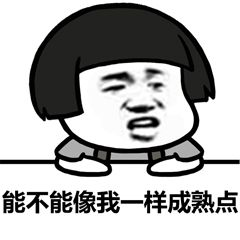

In [24]:
from google.colab.patches import cv2_imshow
import cv2 as cv
predict_imgPath = './test_img.jpg'
img = cv.imread(predict_imgPath)
cv2_imshow(img)
# fig = plt.figure()
# plt.imshow(img)
# fig.show()

Then we can output the prediction of the picture.

Prediction code for v1.3

In [0]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import keras.layers
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1

cardinality = 8  # how many split ?
blocks = 3  # res_block ! (split + transition)
depth = 64  # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""
prediction_dict = ['小猪佩奇', '蘑菇头', '可爱柴犬', '猥琐猫', '猫', '笑', '熊本熊', '熊猫头', '文字', '长草颜']
reduction_ratio = 4
class_num = 10
batch_size = 1

# iteration = 391
# 128 * 391 ~ 50,000

iteration = 1
# 1*1~1

test_iteration = 10

total_epochs = 100


def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
	with tf.name_scope(layer_name):
		network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride,
		                           padding=padding)
		return network


def Global_Average_Pooling(x):
	return global_avg_pool(x, name='Global_avg_pooling')


def Average_pooling(x, pool_size=[2, 2], stride=2, padding='SAME'):
	return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)


def Batch_Normalization(x, training, scope):
	with arg_scope([batch_norm],
	               scope=scope,
	               updates_collections=None,
	               decay=0.9,
	               center=True,
	               scale=True,
	               zero_debias_moving_mean=True):
		return tf.cond(training,
		               lambda: batch_norm(inputs=x, is_training=training, reuse=None),
		               lambda: batch_norm(inputs=x, is_training=training, reuse=True))


def Relu(x):
	return tf.nn.relu(x)


def Sigmoid(x):
	return tf.nn.sigmoid(x)


def Concatenation(layers):
	return tf.concat(layers, axis=3)


def Fully_connected(x, units=class_num, layer_name='fully_connected'):
	with tf.name_scope(layer_name):
		return tf.layers.dense(inputs=x, use_bias=False, units=units)


class SE_ResNeXt():
	def __init__(self, x, training):
		self.training = training
		self.model = self.Build_SEnet(x)

	def first_layer(self, x, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			x = Relu(x)

			return x

	def transform_layer(self, x, stride, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=depth, kernel=[1, 1], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			x = Relu(x)

			x = conv_layer(x, filter=depth, kernel=[3, 3], stride=stride, layer_name=scope + '_conv2')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch2')
			x = Relu(x)
			return x

	def transition_layer(self, x, out_dim, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=out_dim, kernel=[1, 1], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			# x = Relu(x)

			return x

	def split_layer(self, input_x, stride, layer_name):
		with tf.name_scope(layer_name):
			layers_split = list()
			for i in range(cardinality):
				splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
				layers_split.append(splits)

			return Concatenation(layers_split)

	def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
		with tf.name_scope(layer_name):
			squeeze = Global_Average_Pooling(input_x)

			excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name + '_fully_connected1')
			excitation = Relu(excitation)
			excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name + '_fully_connected2')
			excitation = Sigmoid(excitation)

			excitation = tf.reshape(excitation, [-1, 1, 1, out_dim])
			scale = input_x * excitation

			return scale

	def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
		# split + transform(bottleneck) + transition + merge
		# input_dim = input_x.get_shape().as_list()[-1]

		for i in range(res_block):
			input_dim = int(np.shape(input_x)[-1])

			if input_dim * 2 == out_dim:
				flag = True
				stride = 2
				channel = input_dim // 2
			else:
				flag = False
				stride = 1

			x = self.split_layer(input_x, stride=stride, layer_name='split_layer_' + layer_num + '_' + str(i))
			x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_' + layer_num + '_' + str(i))
			x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio,
			                                  layer_name='squeeze_layer_' + layer_num + '_' + str(i))

			if flag is True:
				pad_input_x = Average_pooling(input_x)
				pad_input_x = tf.pad(pad_input_x,
				                     [[0, 0], [0, 0], [0, 0], [channel, channel]])  # [?, height, width, channel]
			else:
				pad_input_x = input_x

			input_x = Relu(x + pad_input_x)

		return input_x

	def Build_SEnet(self, input_x):
		# only cifar10 architecture

		input_x = self.first_layer(input_x, scope='first_layer')

		x = self.residual_layer(input_x, out_dim=64, layer_num='1')
		x = self.residual_layer(x, out_dim=128, layer_num='2')
		x = self.residual_layer(x, out_dim=256, layer_num='3')

		x = Global_Average_Pooling(x)
		x = flatten(x)

		x = Fully_connected(x, layer_name='final_fully_connected')
		return x


predict_x = prepare_data(predict_imgPath)
predict_x = color_preprocessing(predict_x)

# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())
predict_x = data_augmentation(predict_x)
x_feed_dict = {
	x: predict_x,
	training_flag: False
}
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
	ckpt = tf.train.get_checkpoint_state('./model')
	if ckpt and ckpt.model_checkpoint_path:
		global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
		saver.restore(sess, ckpt.model_checkpoint_path)
		print('Loading success')
	else:
		print('No checkpoint')
	prediction = sess.run(logits, feed_dict=x_feed_dict)
max_index = np.argmax(prediction)
result = prediction_dict[max_index]
print(result)

Prediction code for v1.4

In [0]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import keras.layers
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1

cardinality = 8  # how many split ?
blocks = 3  # res_block ! (split + transition)
depth = 64  # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""
prediction_dict = ['小猪佩奇', '蘑菇头', '可爱柴犬', '猥琐猫', '猫', '笑', '熊本熊', '熊猫头', '文字', '长草颜']
reduction_ratio = 4
class_num = 10
batch_size = 1

# iteration = 391
# 128 * 391 ~ 50,000

iteration = 1
# 1*1~1

test_iteration = 10

total_epochs = 100


def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
	with tf.name_scope(layer_name):
		network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride,
		                           padding=padding)
		return network


def Global_Average_Pooling(x):
	return global_avg_pool(x, name='Global_avg_pooling')


def Average_pooling(x, pool_size=[2, 2], stride=2, padding='SAME'):
	return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)


def Batch_Normalization(x, training, scope):
	with arg_scope([batch_norm],
	               scope=scope,
	               updates_collections=None,
	               decay=0.9,
	               center=True,
	               scale=True,
	               zero_debias_moving_mean=True):
		return tf.cond(training,
		               lambda: batch_norm(inputs=x, is_training=training, reuse=None),
		               lambda: batch_norm(inputs=x, is_training=training, reuse=True))


def Relu(x):
	return tf.nn.relu(x)


def Sigmoid(x):
	return tf.nn.sigmoid(x)


def Concatenation(layers):
	return tf.concat(layers, axis=3)


def Fully_connected(x, units=class_num, layer_name='fully_connected'):
	with tf.name_scope(layer_name):
		return tf.layers.dense(inputs=x, use_bias=False, units=units)


class SE_ResNeXt():
	def __init__(self, x, training):
		self.training = training
		self.model = self.Build_SEnet(x)

	def first_layer(self, x, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			x = Relu(x)

			return x

	def transform_layer(self, x, stride, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=depth, kernel=[1, 1], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			x = Relu(x)

			x = conv_layer(x, filter=depth, kernel=[3, 3], stride=stride, layer_name=scope + '_conv2')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch2')
			x = Relu(x)
			return x

	def transition_layer(self, x, out_dim, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=out_dim, kernel=[1, 1], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			# x = Relu(x)

			return x

	def split_layer(self, input_x, stride, layer_name):
		with tf.name_scope(layer_name):
			layers_split = list()
			for i in range(cardinality):
				splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
				layers_split.append(splits)

			return Concatenation(layers_split)

	def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
		with tf.name_scope(layer_name):
			squeeze = Global_Average_Pooling(input_x)

			excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name + '_fully_connected1')
			excitation = Relu(excitation)
			excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name + '_fully_connected2')
			excitation = Sigmoid(excitation)

			excitation = tf.reshape(excitation, [-1, 1, 1, out_dim])
			scale = input_x * excitation

			return scale

	def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
		# split + transform(bottleneck) + transition + merge
		# input_dim = input_x.get_shape().as_list()[-1]

		for i in range(res_block):
			input_dim = int(np.shape(input_x)[-1])

			if input_dim * 2 == out_dim:
				flag = True
				stride = 2
				channel = input_dim // 2
			else:
				flag = False
				stride = 1

			x = self.split_layer(input_x, stride=stride, layer_name='split_layer_' + layer_num + '_' + str(i))
			x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_' + layer_num + '_' + str(i))
			x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio,
			                                  layer_name='squeeze_layer_' + layer_num + '_' + str(i))

			if flag is True:
				pad_input_x = Average_pooling(input_x)
				pad_input_x = tf.pad(pad_input_x,
				                     [[0, 0], [0, 0], [0, 0], [channel, channel]])  # [?, height, width, channel]
			else:
				pad_input_x = input_x

			input_x = Relu(x + pad_input_x)

		return input_x

	def Build_SEnet(self, input_x):
		# only cifar10 architecture

		input_x = self.first_layer(input_x, scope='first_layer')

		x = self.residual_layer(input_x, out_dim=64, layer_num='1')
		x = self.residual_layer(x, out_dim=128, layer_num='2')
		x = self.residual_layer(x, out_dim=256, layer_num='3')
    x = self.residual_layer(x, out_dim=512, layer_num='4')

		x = Global_Average_Pooling(x)
		x = flatten(x)

		x = Fully_connected(x, layer_name='final_fully_connected')
		return x


predict_x = prepare_data(predict_imgPath)
predict_x = color_preprocessing(predict_x)

# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())
predict_x = data_augmentation(predict_x)
x_feed_dict = {
	x: predict_x,
	training_flag: False
}
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
	ckpt = tf.train.get_checkpoint_state('./model')
	if ckpt and ckpt.model_checkpoint_path:
		global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
		saver.restore(sess, ckpt.model_checkpoint_path)
		print('Loading success')
	else:
		print('No checkpoint')
	prediction = sess.run(logits, feed_dict=x_feed_dict)
max_index = np.argmax(prediction)
result = prediction_dict[max_index]
print(result)

Prediction code for v1.5

In [0]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import keras.layers
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1

cardinality = 8  # how many split ?
blocks = 3  # res_block ! (split + transition)
depth = 64  # out channel

"""
So, the total number of layers is (3*blokcs)*residual_layer_num + 2
because, blocks = split(conv 2) + transition(conv 1) = 3 layer
and, first conv layer 1, last dense layer 1
thus, total number of layers = (3*blocks)*residual_layer_num + 2
"""
prediction_dict = ['小猪佩奇', '蘑菇头', '可爱柴犬', '猥琐猫', '猫', '笑', '熊本熊', '熊猫头', '文字', '长草颜']
reduction_ratio = 4
class_num = 10
batch_size = 1

# iteration = 391
# 128 * 391 ~ 50,000

iteration = 1
# 1*1~1

test_iteration = 10

total_epochs = 100


def conv_layer(input, filter, kernel, stride, padding='SAME', layer_name="conv"):
	with tf.name_scope(layer_name):
		network = tf.layers.conv2d(inputs=input, use_bias=False, filters=filter, kernel_size=kernel, strides=stride,
		                           padding=padding)
		return network


def Global_Average_Pooling(x):
	return global_avg_pool(x, name='Global_avg_pooling')


def Average_pooling(x, pool_size=[2, 2], stride=2, padding='SAME'):
	return tf.layers.average_pooling2d(inputs=x, pool_size=pool_size, strides=stride, padding=padding)


def Batch_Normalization(x, training, scope):
	with arg_scope([batch_norm],
	               scope=scope,
	               updates_collections=None,
	               decay=0.9,
	               center=True,
	               scale=True,
	               zero_debias_moving_mean=True):
		return tf.cond(training,
		               lambda: batch_norm(inputs=x, is_training=training, reuse=None),
		               lambda: batch_norm(inputs=x, is_training=training, reuse=True))


def Relu(x):
	return tf.nn.relu(x)


def Sigmoid(x):
	return tf.nn.sigmoid(x)


def Concatenation(layers):
	return tf.concat(layers, axis=3)


def Fully_connected(x, units=class_num, layer_name='fully_connected'):
	with tf.name_scope(layer_name):
		return tf.layers.dense(inputs=x, use_bias=False, units=units)


class SE_ResNeXt():
	def __init__(self, x, training):
		self.training = training
		self.model = self.Build_SEnet(x)

	def first_layer(self, x, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=64, kernel=[3, 3], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			x = Relu(x)

			return x

	def transform_layer(self, x, stride, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=depth, kernel=[1, 1], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			x = Relu(x)

			x = conv_layer(x, filter=depth, kernel=[3, 3], stride=stride, layer_name=scope + '_conv2')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch2')
			x = Relu(x)
			return x

	def transition_layer(self, x, out_dim, scope):
		with tf.name_scope(scope):
			x = conv_layer(x, filter=out_dim, kernel=[1, 1], stride=1, layer_name=scope + '_conv1')
			x = Batch_Normalization(x, training=self.training, scope=scope + '_batch1')
			# x = Relu(x)

			return x

	def split_layer(self, input_x, stride, layer_name):
		with tf.name_scope(layer_name):
			layers_split = list()
			for i in range(cardinality):
				splits = self.transform_layer(input_x, stride=stride, scope=layer_name + '_splitN_' + str(i))
				layers_split.append(splits)

			return Concatenation(layers_split)

	def squeeze_excitation_layer(self, input_x, out_dim, ratio, layer_name):
		with tf.name_scope(layer_name):
			squeeze = Global_Average_Pooling(input_x)

			excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name + '_fully_connected1')
			excitation = Relu(excitation)
			excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name + '_fully_connected2')
			excitation = Sigmoid(excitation)

			excitation = tf.reshape(excitation, [-1, 1, 1, out_dim])
			scale = input_x * excitation

			return scale

	def residual_layer(self, input_x, out_dim, layer_num, res_block=blocks):
		# split + transform(bottleneck) + transition + merge
		# input_dim = input_x.get_shape().as_list()[-1]

		for i in range(res_block):
			input_dim = int(np.shape(input_x)[-1])

			if input_dim * 2 == out_dim:
				flag = True
				stride = 2
				channel = input_dim // 2
			else:
				flag = False
				stride = 1

			x = self.split_layer(input_x, stride=stride, layer_name='split_layer_' + layer_num + '_' + str(i))
			x = self.transition_layer(x, out_dim=out_dim, scope='trans_layer_' + layer_num + '_' + str(i))
			x = self.squeeze_excitation_layer(x, out_dim=out_dim, ratio=reduction_ratio,
			                                  layer_name='squeeze_layer_' + layer_num + '_' + str(i))

			if flag is True:
				pad_input_x = Average_pooling(input_x)
				pad_input_x = tf.pad(pad_input_x,
				                     [[0, 0], [0, 0], [0, 0], [channel, channel]])  # [?, height, width, channel]
			else:
				pad_input_x = input_x

			input_x = Relu(x + pad_input_x)

		return input_x

	def Build_SEnet(self, input_x):
		# only cifar10 architecture

		input_x = self.first_layer(input_x, scope='first_layer')

		x = self.residual_layer(input_x, out_dim=64, layer_num='1')
		x = self.residual_layer(x, out_dim=128, layer_num='2')

		x = Global_Average_Pooling(x)
		x = flatten(x)

		x = Fully_connected(x, layer_name='final_fully_connected')
		return x


predict_x = prepare_data(predict_imgPath)
predict_x = color_preprocessing(predict_x)

# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_ResNeXt(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())
predict_x = data_augmentation(predict_x)
x_feed_dict = {
	x: predict_x,
	training_flag: False
}
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
	ckpt = tf.train.get_checkpoint_state('./model')
	if ckpt and ckpt.model_checkpoint_path:
		global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
		saver.restore(sess, ckpt.model_checkpoint_path)
		print('Loading success')
	else:
		print('No checkpoint')
	prediction = sess.run(logits, feed_dict=x_feed_dict)
max_index = np.argmax(prediction)
result = prediction_dict[max_index]
print(result)